# Sentiment Classification


### Importing Packages

In [40]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from keras.models import Model, Sequential
from tensorflow.keras.layers import Embedding, LSTM, TimeDistributed, Flatten, Dense,MaxPooling1D,Dropout,Conv1D
from keras.callbacks import ModelCheckpoint, EarlyStopping
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split

### Loading the dataset (5 points)

In [3]:
from keras.datasets import imdb

vocab_size = 10000 #vocab size

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=vocab_size) # vocab_size is no.of words to consider from the dataset, ordering based on frequency.

17465344/17464789 [==============================] - 0s 0us/step


In [4]:
from keras.preprocessing.sequence import pad_sequences
vocab_size = 10000 #vocab size
maxlen = 300  #number of word used from each review

## Train test split ( 5 points)

In [5]:
#load dataset as a list of ints
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=vocab_size)
#make all sequences of the same length
x_train = pad_sequences(x_train, maxlen=maxlen)
x_test =  pad_sequences(x_test, maxlen=maxlen)

In [6]:
x=np.concatenate((x_train,x_test),axis=0)
y=np.concatenate((y_train,y_test),axis=0)

In [13]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0, shuffle = True)

In [14]:
#printing the shape
print('Shape of X_train :',x_train.shape)
print('Shape of y_train :',y_train.shape)
print('Shape of X_test :',x_test.shape)
print('Shape of y_test :',x_test.shape)

Shape of X_train : (40000, 300)
Shape of y_train : (40000,)
Shape of X_test : (10000, 300)
Shape of y_test : (10000, 300)


In [15]:
train_len = [len(sequence) for sequence in x_train]
test_len = [len(sequence) for sequence in x_test]
print('Maximum value of a word index:', max([max(sequence) for sequence in x_train]))
print('Maximum length num words of review in train:', max([len(sequence) for sequence in x_train]))

Maximum value of a word index: 9999
Maximum length num words of review in train: 300


In [16]:
unique, counts = np.unique(np.concatenate((y_train, y_test)), return_counts=True)
sentiments = {1: 'Positive', 0: 'Negative'}

def interprete_review(sequence):
    id_to_word = dict([(value, key) for (key, value) in imdb.get_word_index().items()])
    decoded_review = ' '.join([id_to_word.get(idx-3, '?') for idx in sequence])
    print(decoded_review)
    
review_id1 = np.random.choice(train_len)
interprete_review(x_train[review_id1])
print('The sentiment for the above review is:', sentiments.get(y_train[review_id1]))
print('\n')
review_id2 = np.random.choice(test_len)
interprete_review(x_test[review_id2])
print('The sentiment for the above review is:', sentiments.get(y_test[review_id2]))

1646592/1641221 [==============================] - 0s 0us/step
especially the ? and the ? another problem of course is the huge gaps in the plot bakshi was in a rush to finish this movie and he somehow hoped to ? a book and a half in little more than two hours the new trilogy by peter jackson does it in about twice that time far too many important bits were left out and i don't refer only to tom ? which i think was lovely in the book but would look silly in a movie and of course the ending which is completely sudden and out of place i'm not even sure if bakshi originally intended to end the film there or if he even had any idea where he's going to end it br br the characters well most of them were okay the ? don't look so bad except for the gay sam did you know that the producers of the new trilogy originally wanted to make sam a woman so there would be a feminine lead character if you're a ? fanatic like me watch this movie though i'm not too sure about buying it what special features

## Build Keras Embedding Layer Model (30 points)
We can think of the Embedding layer as a dicionary that maps a index assigned to a word to a word vector. This layer is very flexible and can be used in a few ways:

* The embedding layer can be used at the start of a larger deep learning model. 
* Also we could load pre-train word embeddings into the embedding layer when we create our model.
* Use the embedding layer to train our own word2vec models.

The keras embedding layer doesn't require us to onehot encode our words, instead we have to give each word a unqiue intger number as an id. For the imdb dataset we've loaded this has already been done, but if this wasn't the case we could use sklearn [LabelEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html).

In [23]:
# Model
model = Sequential()
model.add(Embedding(vocab_size, 256, input_length = maxlen))
model.add(Dropout(0.25))
model.add(Conv1D(256, 5, padding = 'same', activation = 'relu', strides = 1))
model.add(Conv1D(128, 5, padding = 'same', activation = 'relu', strides = 1))
model.add(MaxPooling1D(pool_size = 2))
model.add(Conv1D(64, 5, padding = 'same', activation = 'relu', strides = 1))
model.add(MaxPooling1D(pool_size = 2))
model.add(LSTM(75))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
print(model.summary())

# Adding callbacks
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 0)  
mc = ModelCheckpoint('imdb_model.h5', monitor = 'val_loss', mode = 'min', save_best_only = True, verbose = 1)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 300, 256)          2560000   
_________________________________________________________________
dropout_2 (Dropout)          (None, 300, 256)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 300, 256)          327936    
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 300, 128)          163968    
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 150, 128)          0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 150, 64)           41024     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 75, 64)           

In [24]:
epochs = 5
batches = 128
#using 20% of data as validation set
history = model.fit(x_train, y_train, epochs = epochs, batch_size = batches, validation_split = 0.2,verbose = True, callbacks = [es, mc]) 

Epoch 1/5
250/250 [==============================] - 29s 83ms/step - loss: 0.5080 - accuracy: 0.7088 - val_loss: 0.2586 - val_accuracy: 0.8947

Epoch 00001: val_loss improved from inf to 0.25861, saving model to imdb_model.h5
Epoch 2/5
250/250 [==============================] - 20s 82ms/step - loss: 0.1829 - accuracy: 0.9301 - val_loss: 0.2698 - val_accuracy: 0.8850

Epoch 00002: val_loss did not improve from 0.25861
Epoch 00002: early stopping


## Accuracy of the model  & Retrive the output of each layer in keras for a given single test sample from the trained model you built (10 Points)

In [26]:
tr_loss, tr_acc = model.evaluate(x_train, y_train)
print('Training Loss: %.4f and Accuracy: %.2f%%' % (tr_loss, tr_acc * 100))

loss, acc = model.evaluate(x_test, y_test)
print('Test Loss: %.4f and Accuracy: %.2f%%' % (loss, acc * 100))

1250/1250 [==============================] - 9s 7ms/step - loss: 0.1729 - accuracy: 0.9360
Training Loss: 0.1729 and Accuracy: 93.60%
313/313 [==============================] - 2s 7ms/step - loss: 0.2658 - accuracy: 0.8906
Test Loss: 0.2658 and Accuracy: 89.06%


**Observation**

- Test acuracy = 89.06%
-Train accuracy is 93.6%
- Model is Overfitting


Testing accuracy: 89.05999999999999

 Confusion matrix:
 [[4132  861]
 [ 233 4774]]


Text(0.5, 1.0, 'Confusion Matrix ')

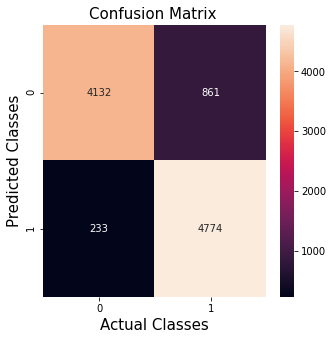

In [32]:

from sklearn.metrics import confusion_matrix, classification_report,  accuracy_score
y_pred = model.predict_classes(x_test)

print('\nTesting accuracy:', (accuracy_score(y_test, y_pred) * 100))

cfm_model = confusion_matrix(y_test, y_pred)
print('\n Confusion matrix:\n', cfm_model)

plt.figure(figsize = (5, 5))
sns.heatmap(cfm_model, annot = True, fmt = 'd')
plt.xlabel('Actual Classes', fontsize = 15)
plt.ylabel('Predicted Classes', fontsize = 15)
plt.title('Confusion Matrix ', fontsize = 15)

In [38]:
# Predicting the sentiment for a random pre-defined review from IMDB dataset
review_id = np.random.choice(test_len)
interprete_review(x_test[review_id])
print('ACTUAL sentiment:', sentiments.get(y_test[review_id]))

prediction = model.predict_classes(pad_sequences([x_test[review_id]], maxlen = maxlen))
print('PREDICTED sentiment:', sentiments.get(prediction[0][0]))

adventure alive especially when one of the soldiers is against all types of violence and another one continuously stares at video images of her cute 3 year old son the hills have eyes ii completely lacks  as to be expected  originality logic and plausible situations the mutated ? aren't nearly as menacing as their colleagues in part one mainly because they aren't organized this time and only just behave like ? and sex hungry prototype monsters since you don't care for the amateur g i joe heroes and definitely don't feel any sympathy for the eyes in the hills this film is a whole lot less compelling and involving than last year's original most ? this second film isn't nearly as violent and gory as the first sequels usually compensate the lack of suspense and the absence of surprise twists with extra bloodshed and more graphic killing sequences but the action in this sequel is really tame compared to the sick footage featuring in its predecessor there are a handful of scenes to satisfy

### Output of each layers

In [41]:
sample_x_test = x_test[np.random.randint(10000)]
for layer in model.layers:

    model_layer = Model(inputs = model.input, outputs = model.get_layer(layer.name).output)
    output = model_layer.predict(sample_x_test.reshape(1,-1))
    print('\n','--'*20, layer.name, 'layer', '--'*20, '\n')
    print(output)


 ---------------------------------------- embedding_3 layer ---------------------------------------- 

[[[-0.01087046 -0.02226283 -0.01529966 ...  0.00508994 -0.03526138
   -0.01275799]
  [-0.01087046 -0.02226283 -0.01529966 ...  0.00508994 -0.03526138
   -0.01275799]
  [-0.01087046 -0.02226283 -0.01529966 ...  0.00508994 -0.03526138
   -0.01275799]
  ...
  [ 0.01491141  0.02168479 -0.02027915 ... -0.04847545  0.00731946
    0.00660094]
  [ 0.01491141  0.02168479 -0.02027915 ... -0.04847545  0.00731946
    0.00660094]
  [ 0.01491141  0.02168479 -0.02027915 ... -0.04847545  0.00731946
    0.00660094]]]

 ---------------------------------------- dropout_2 layer ---------------------------------------- 

[[[-0.01087046 -0.02226283 -0.01529966 ...  0.00508994 -0.03526138
   -0.01275799]
  [-0.01087046 -0.02226283 -0.01529966 ...  0.00508994 -0.03526138
   -0.01275799]
  [-0.01087046 -0.02226283 -0.01529966 ...  0.00508994 -0.03526138
   -0.01275799]
  ...
  [ 0.01491141  0.02168479 -0.020